# **Data Processing**

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 198 kB 55.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=03980e60d5f250b05f8c8890441945109ae711e215d92156b710d39d84d956af
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
import pyspark #
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F
import os
import seaborn as sns
import sklearn #
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib #
import matplotlib.pyplot as plt

In [4]:
os.environ["SPARK_LOCAL_IP"]='127.0.0.1'
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext._conf.getAll()
print("pyspark: {}".format(pyspark.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))

pyspark: 3.2.0
matplotlib: 3.2.2
seaborn: 0.11.2
sklearn: 1.0.1


In [5]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


* Load credit card data set
* PySpark has its own functionality for creating data frames.
* No need to use pandas.

In [6]:
data_path = 'creditcard.csv'
df = spark.read.csv(data_path, header = True, inferSchema = True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove(labelColumn)
print(numericCols)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


* The output of the Spark data frame.

In [7]:
df.show(2)

+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
|Time|              V1|                 V2|              V3|               V4|                V5|                 V6|                 V7|                V8|                V9|               V10|               V11|               V12|               V13|               V14|              V15|               V16|               V17|               V18|               V19|                V20|               V21|               V22|               V23|       

* Make sure to convert Spark data frame to pandas if it has a lot of columns.

In [8]:
df.toPandas().head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


* The data processing procedure for PySpark is slightly different than in pandas. 
* To train the model, pass in a vector called features.

In [9]:
stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
dfFeatures = df.select(F.col(labelColumn).alias('label'), *numericCols )

* Create the normal and anomaly data splits.

In [10]:
normal = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020)
anomaly = dfFeatures.filter("Class == 1")
normal_train, normal_test = normal.randomSplit([0.8, 0.2], seed = 2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2], seed = 2020)

* 80-20 split between the training and testing data.

In [11]:
train = normal_train.union(anomaly_train)
test = normal_test.union(anomaly_test)

* Finish the rest of the pipeline and create the feature vector.

In [12]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(dfFeatures)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)
selectedCols = ['label', 'features'] + numericCols
train = train.select(selectedCols)
test = test.select(selectedCols)

print("Training Dataset Count: ", train.count())
print("Test Dataset Count: ", test.count())

Training Dataset Count:  114138
Test Dataset Count:  28608


# **Model Training**

* Define and train the model.

In [13]:
lr = LogisticRegressionPySpark(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary
pyspark_auc_score = trainingSummary.areaUnderROC

# **Model Evaluation**

* Run the evaluation code.

In [14]:
predictions = lrModel.transform(test)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
evaluations = lrModel.evaluate(test)
accuracy = evaluations.accuracy

* Display the metrics.

In [15]:
print(f"AUC Score: {roc_auc_score(y_pred, y_true):.3%}")
print(f"PySpark AUC Score: {pyspark_auc_score:.3%}")
print(f"Accuracy Score: {accuracy:.3%}")

AUC Score: 95.674%
PySpark AUC Score: 98.693%
Accuracy Score: 99.899%


* Look at the ROC curve.

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


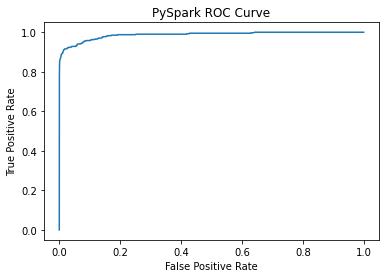

In [16]:
pyspark_roc = trainingSummary.roc.toPandas()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PySpark ROC Curve')
plt.plot(pyspark_roc['FPR'],pyspark_roc['TPR'])

* Look at the confusion matrix to get a detailed idea of how the model performs.

Text(0.5, 15.0, 'Predicted')

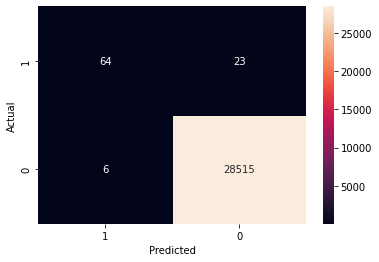

In [17]:
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

The accuracy of correctly labeled points for the normal data is very high and is decent for the anomalous data.